In [4]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.12.0 to work with Pycon2020


In [5]:
experiment_name = 'DurianvsJackfruit_Experiment'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [6]:
# Setup the compute target
# compute_target = 'local'      # lOCAL
compute_target = "cc-pycon2020" # REMOTE CLUSTER

# Traning variables
n_epochs = 2
learning_rate=0.001

In [7]:
import os, shutil

# Create a folder for the experiment files
folder_name = 'durian-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

In [36]:
%%writefile $experiment_folder/train.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from azureml.core import Run

import azureml.core
from azureml.core import Workspace

# import joblib

# from scikit-learn.externals import joblib

# Get parameters
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder reference')
parser.add_argument('--epochs', type=str, dest='epochs', default="1", help='number of epochs')
parser.add_argument('--learning-rate', type=float, dest='l_rate', default=0.005, help='learning rate')
parser.add_argument('--output_folder', type=str, dest='output_folder', default="outputs", help='output folder')

args = parser.parse_args()
data_folder = args.data_folder
epochs = int(args.epochs)
lrate = args.l_rate
output_folder = args.output_folder

data_dir = data_folder
print('Mounting at: ',data_dir)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ',device)
print('Epochs:',str(epochs))
print('Learning Rate',lrate)

CUDA_LAUNCH_BLOCKING=1 
#number of colors on images (B&W=1, RGB=3)
num_channels = 3
model_save_path = 'durian.pth'

#
# Do Data Transformations and load into Dataloader
#
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([256, 256]),        
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.ToTensor(),
    ])   
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            shuffle=True, num_workers=4)
            for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

class_names = image_datasets['train'].classes

print('Classes loaded:',class_names)

num_letters = len(class_names)

def train_model(net, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    lowest_loss = 100.0
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # Set model to training mode
            else:
                net.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.7f} Acc: {:.7f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
            if phase == 'val' and epoch_loss < lowest_loss:
                lowest_loss = epoch_loss
                best_model_wts = copy.deepcopy(net.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest val loss: {:4f}'.format(lowest_loss))

    print('accuracy: ' + str(best_acc))
    run.log('accuracy', float(best_acc.cpu().numpy()))
            
    print('Loss: ' + str(lowest_loss))
    run.log('loss', float(lowest_loss))        
        
    print('Finished Training')
    return net
    
run = Run.get_context()

print('Started training')

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

print('Number of classes:',len(class_names))
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lrate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

net = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

print('Model trained.')

# torch.save(net.state_dict(), model_save_path)

os.makedirs(output_folder, exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
# joblib.dump(value=clf, filename=output_folder+'/'+model_save_path)
torch.save(net, output_folder+'/'+model_save_path)

run.complete()

Overwriting ./durian-experiment-files/train.py


In [9]:
from azureml.core import Datastore,Dataset

datastore = Datastore.get(ws, 'pycon2020_source_images')
planes_ds = Dataset.File.from_files((datastore, 'durian/*/*/*'))

In [37]:
# from azureml.train.sklearn import SKLearn
from azureml.core import Experiment
from azureml.widgets import RunDetails
from azureml.train.dnn import PyTorch

# Set up the parameters
script_params = {
    '--data-folder': planes_ds.as_named_input('pycon2020_source_images').as_mount(),
    '--epochs': n_epochs,
    '--learning-rate': learning_rate
}

# Create an estimator
from azureml.train.estimator import Estimator

estimator = Estimator(source_directory=experiment_folder,
        script_params=script_params,
        compute_target=compute_target,
        entry_script='train.py',
        use_gpu=True,
        pip_packages=['azureml-dataprep[pandas,fuse]'],
        conda_packages=['pytorch','torchvision'])

# Run the experiment
run = exp.submit(config=estimator)

# Show the run details while running
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'DurianvsJackfruit_Experiment_1599752359_0f3f86dd',
 'target': 'cc-pycon2020',
 'status': 'Finalizing',
 'startTimeUtc': '2020-09-10T15:39:37.123671Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '04a1d855-384e-44da-a314-0f94a43cafe2',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '55982bad-7939-4597-a385-0ad5769f1a3f'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'pycon2020_source_images', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'scriptType': None,
  'useAbsolutePath': False,
  'arguments': ['--data-folder',
   'DatasetConsumptionConfig:pycon2020_source_images',
   '--epochs',
   '2',
   '--learning-rate',
   '0.001'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cc-pycon2020',
  'dataReferences': {},
  'data': {'py

In [25]:
print(run.get_file_names())

['azureml-logs/55_azureml-execution-tvmps_07f303cdc97024e4c09c7f0f42a40237b2b2c2b02a68b8872076806e9df75c2f_d.txt', 'azureml-logs/65_job_prep-tvmps_07f303cdc97024e4c09c7f0f42a40237b2b2c2b02a68b8872076806e9df75c2f_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_07f303cdc97024e4c09c7f0f42a40237b2b2c2b02a68b8872076806e9df75c2f_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/122_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/dataprep/engine_spans_l_da2d233b-3655-4286-b1b0-2910a7e0e494.jsonl', 'logs/azureml/dataprep/engine_spans_l_f24e16e2-5bfb-4ede-b9eb-11396579ad04.jsonl', 'logs/azureml/dataprep/python_span_l_da2d233b-3655-4286-b1b0-2910a7e0e494.jsonl', 'logs/azureml/dataprep/python_span_l_f24e16e2-5bfb-4ede-b9eb-11396579ad04.jsonl', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log', 'outputs/durian.pth']


## Register model

In [38]:
model_save_path = 'durian.pth'

# register model 
model = run.register_model(model_name='durian', model_path='outputs/durian.pth')
print(model.name, model.id, model.version, sep='\t')

durian	durian:2	2


## Deploy model

In [39]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(pip_packages=['azureml-defaults', 'torch', 'torchvision>=0.5.0'])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())
    
print(myenv.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults
  - torch
  - torchvision>=0.5.0
channels:
- anaconda
- conda-forge



In [40]:
%%writefile score.py
import os
import torch
import torch.nn as nn
from torchvision import transforms
import json

from azureml.core.model import Model


def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'durian.pth')
    model = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.eval()


def run(input_data):
    input_data = torch.tensor(json.loads(input_data)['data'])

    # get prediction
    with torch.no_grad():
        output = model(input_data)
        classes = ['Durian', 'Jackfruit']
        softmax = nn.Softmax(dim=1)
        pred_probs = softmax(output).numpy()[0]
        index = torch.argmax(output, 1)

    result = {"label": classes[index], "probability": str(pred_probs[index])}
    return result

Overwriting score.py


In [42]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment


myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'data': 'Durians and Jackfruits',  
                                                     'method':'transfer learning', 'framework':'pytorch'},
                                               description='Classify Durians/Jackfruits using transfer learning with PyTorch')

service = Model.deploy(workspace=ws, 
                           name='aci-durian', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)
service.wait_for_deployment(True)
print(service.state)

Running....................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [43]:
service.get_logs()

'2020-09-10T15:44:36,330285499+00:00 - iot-server/run \n2020-09-10T15:44:36,330802700+00:00 - rsyslog/run \n2020-09-10T15:44:36,330285499+00:00 - gunicorn/run \n2020-09-10T15:44:36,529306160+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_12ae5ff9bfdf849c113607f65d999bf1/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_12ae5ff9bfdf849c113607f65d999bf1/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_12ae5ff9bfdf849c113607f65d999bf1/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_12ae5ff9bfdf849c113607f65d999bf1/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_12ae5ff9bfdf849c113607f65d999bf1/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)

In [44]:
print(service.scoring_uri)

http://bc33c818-47c7-441e-a78d-02b68857d452.southeastasia.azurecontainer.io/score


## Invoke scoring Web Service

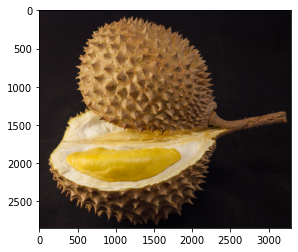

In [70]:
import json
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

import urllib.request

ImageFile.LOAD_TRUNCATED_IMAGES = True

URL = 'https://upload.wikimedia.org/wikipedia/commons/b/bc/Durian_in_black.jpg'

request = urllib.request.Request(URL)
response = urllib.request.urlopen(request)

%matplotlib inline
plt.imshow(Image.open(response))

In [54]:
import torch
from torchvision import transforms
    
def preprocess(image_file):
    """Preprocess the input image."""
    data_transforms = transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.ToTensor()
    ])

    image = Image.open(image_file)
    image = data_transforms(image).float()
    image = torch.tensor(image)
    image = image.unsqueeze(0)
    return image.numpy()

In [75]:
import urllib.request

URL = 'https://upload.wikimedia.org/wikipedia/commons/b/bc/Durian_in_black.jpg'

request = urllib.request.Request(URL)
image = urllib.request.urlopen(request)

input_data = preprocess(image)
result = service.run(input_data=json.dumps({'data': input_data.tolist()}))
print(result)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


{'label': 'Durian', 'probability': '0.9805165'}
